In [91]:
# Function to read the static file
def read_static(static_file):
    with open(static_file, 'r') as f:
        num_particles = int(f.readline().strip())
        square_side_length = float(f.readline().strip())
        particles = []
        for _ in range(num_particles):
            radius, prop = map(float, f.readline().strip().split())
            particles.append({'radius': radius, 'prop': prop})
    return square_side_length, particles

# Function to read the dynamic file
def read_dynamic(dynamic_file):
    with open(dynamic_file, 'r') as f:
        positions = []
        f.readline()  # skip first line
        for line in f:
            x, y = map(float, line.strip().split()[:2])
            positions.append({'x': x, 'y': y})
    return positions

# Function to read the output file
def read_output(output_file):
    with open(output_file, 'r') as f:
        execution_time = float(f.readline().strip())  # read exec time
        neighbors = {}
        for line in f:
            parts = line.strip().split('\t', 1)
            index = int(parts[0])
            if len(parts) == 2 and parts[1]:
                neighbor_list = parts[1]
                neighbors[index] = list(map(int, neighbor_list.split(', ')))
            else:
                neighbors[index] = []
    return execution_time, neighbors

static_file = "particles_static.txt"
dynamic_file = "particles_dynamic.txt"
output_file = "out.txt"

In [93]:
square_side_length, particles = read_static(static_file)
positions = read_dynamic(dynamic_file)
execution_time, neighbors = read_output(output_file)

In [ ]:
square_side_length, particles, positions, execution_time, neighbors

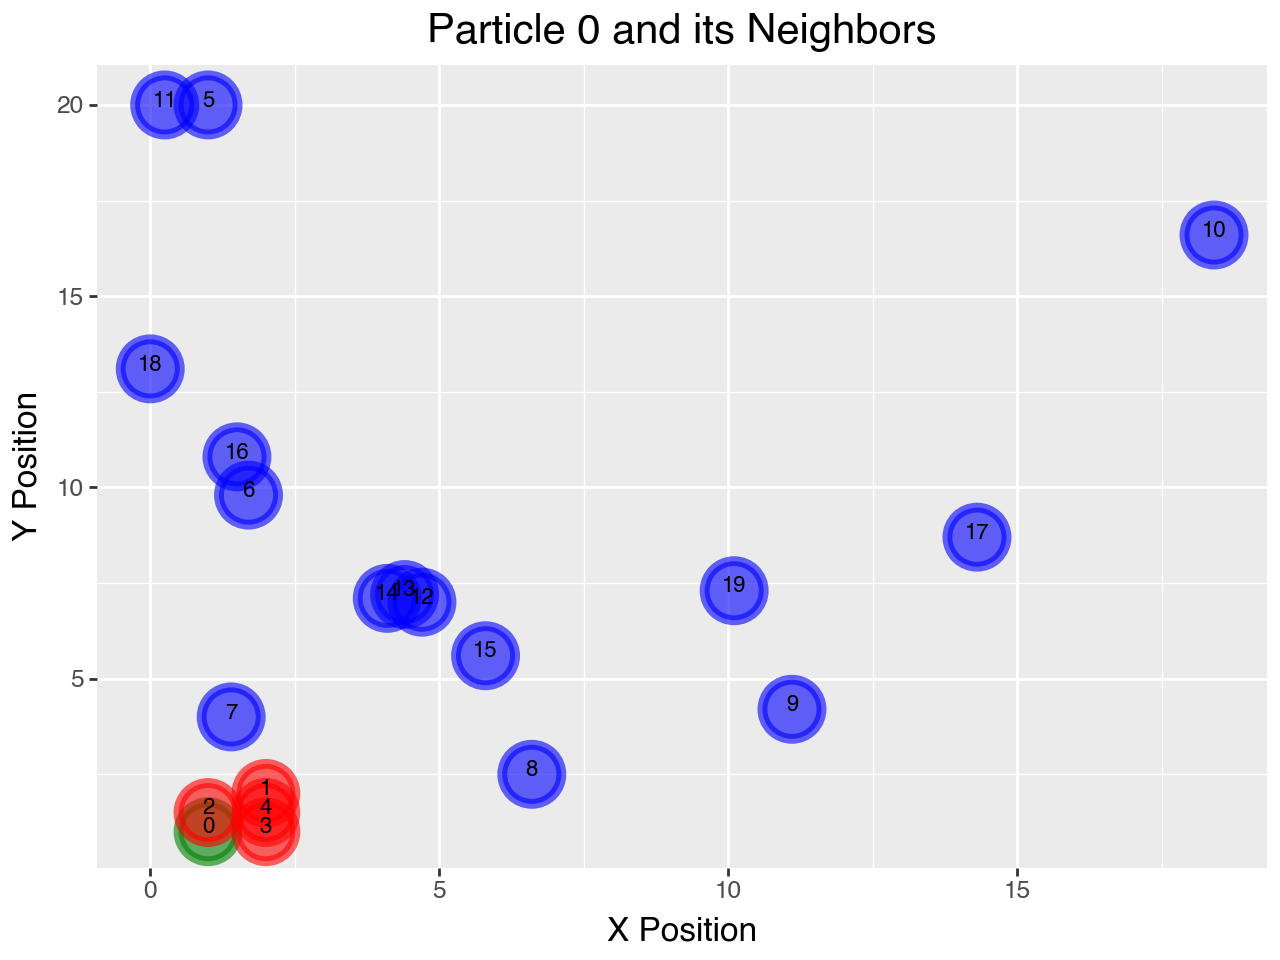

In [94]:
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_line, geom_text, theme, element_text, labs, scale_size, scale_color_manual

def plot_particle_with_neighbors(positions, particles, neighbors, particle_id):
    data = pd.DataFrame({
        'x': [pos['x'] for pos in positions],
        'y': [pos['y'] for pos in positions],
        'size': [particle['radius']  for particle in particles],  # Scale the radius for better visibility
        'color': ['blue'] * len(positions),
        'index': [str(i) for i in range(len(particles))]
    })

    # Set the color for the selected particle and its neighbors
    data.loc[particle_id, 'color'] = 'red'
    for neighbor_id in neighbors.get(particle_id, []):
        data.loc[neighbor_id, 'color'] = 'green'

    p = (ggplot(data, aes(x='x', y='y', size='size', color='color', label='index'))
         + geom_point(alpha=0.6, stroke=2)
         + geom_text(aes(label='index'), nudge_y=0.1, size=8, color='black')
         + scale_size(range=(1, 10))
         + scale_color_manual(values=['blue', 'red', 'green'])

         + labs(title=f"Particle {particle_id} and its Neighbors", x="X Position", y="Y Position")
         + theme(legend_position='none',
                 plot_title=element_text(size=15, face='bold'),
                 axis_title_x=element_text(size=12),
                 axis_title_y=element_text(size=12))
        )

    p.show()

plot_particle_with_neighbors(positions, particles, neighbors, 0)

In [35]:
import os
from pprint import pprint

def generate_input_files(N, L, r):
    os.system(f"python generate_random_input.py --N {N} --L {L} --radius {r}")

def compute_cim(rc, m, periodic):
    os.system(f"python main.py --static_file particles_static.txt --dynamic_file particles_dynamic.txt --rc {rc} --m {m} --brute_force False --periodic_boundaries {periodic}")
    execution_time, neighbors = read_output(output_file)
    return execution_time

def compute_bf(rc):
    os.system(f"python main.py --static_file particles_static.txt --dynamic_file particles_dynamic.txt ---rc {rc} --brute_force True")

def test():
    L = 20
    rc = 1
    r = 0.25
    N_values = [100, 250, 500, 1000, 2000, 5000, 10000]
    M_values = [1, 2, 3, 5, 8, 13, 21, 34, 55]

    cim_times = []
   # bf_times = []

    result_data = []

    for N in N_values:
        generate_input_files(N, L, r)

        for m in M_values:
            cim_time = compute_cim(rc, m, False)
            cim_times.append(cim_time)
            result_data.append({ 'Method': 'CIM', 'N': N, 'M': m, 'Time': cim_time})

    return result_data

result = test()
pprint(result)

Execution time: 0.000263 seconds
Execution time: 0.000275 seconds
Execution time: 0.000285 seconds
Execution time: 0.000274 seconds
Execution time: 0.000266 seconds
Execution time: 0.000429 seconds
Execution time: 0.000289 seconds
Execution time: 0.000355 seconds
Execution time: 0.000244 seconds
Execution time: 0.000865 seconds
Execution time: 0.000906 seconds
Execution time: 0.000858 seconds
Execution time: 0.000854 seconds
Execution time: 0.000867 seconds
Execution time: 0.000863 seconds
Execution time: 0.000861 seconds
Execution time: 0.000853 seconds
Execution time: 0.000917 seconds
Execution time: 0.002634 seconds
Execution time: 0.002853 seconds
Execution time: 0.002982 seconds
Execution time: 0.002949 seconds
Execution time: 0.003086 seconds
Execution time: 0.002862 seconds
Execution time: 0.002844 seconds
Execution time: 0.002522 seconds
Execution time: 0.002744 seconds
Execution time: 0.009688 seconds
Execution time: 0.008861 seconds
Execution time: 0.008974 seconds
Execution 

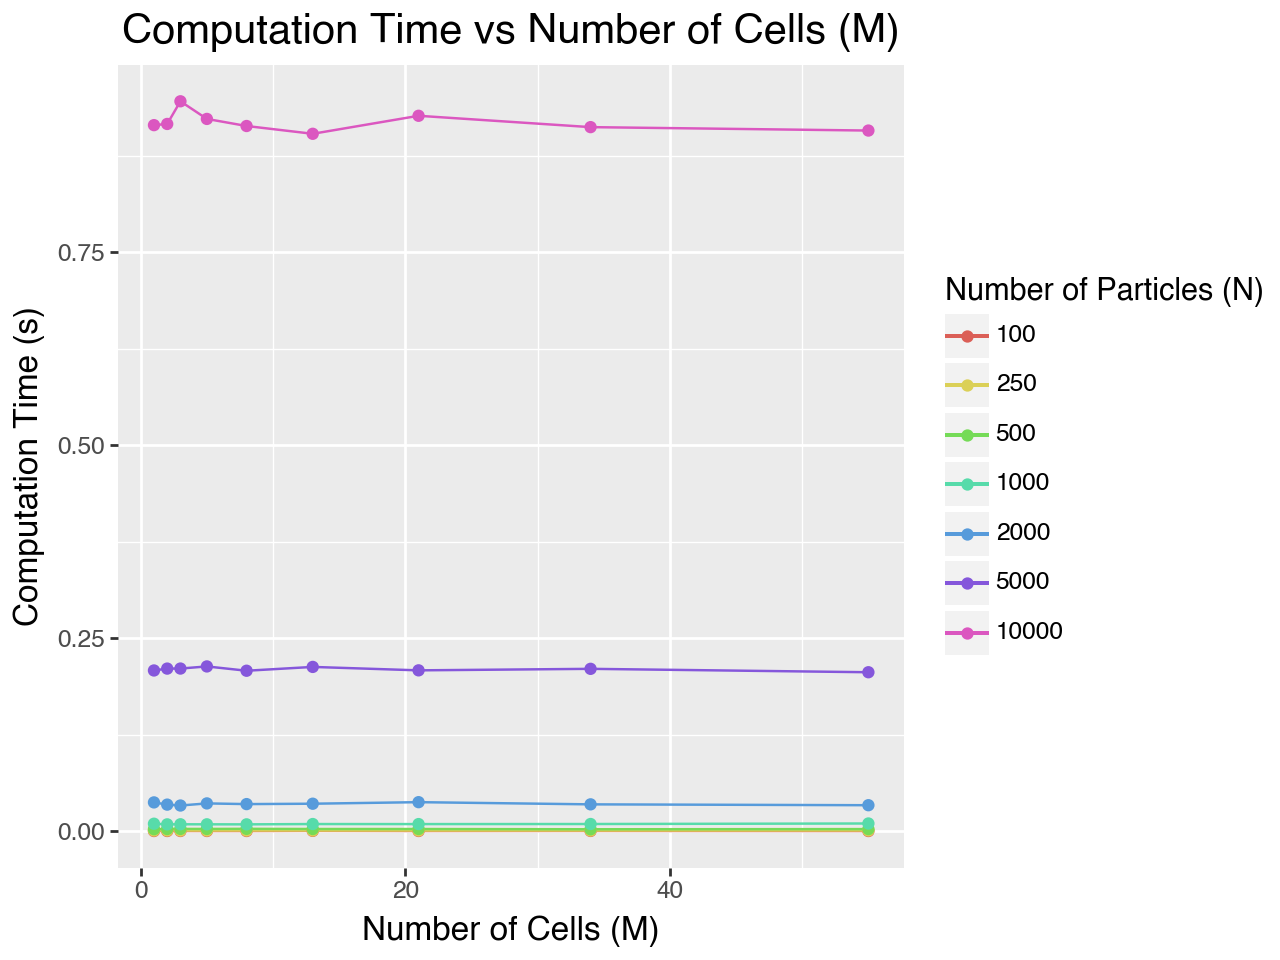

In [45]:
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme, element_text, scale_color_discrete

df = pd.DataFrame(result)

p = (ggplot(df, aes(x='M', y='Time', color='factor(N)'))
     + geom_line()
     + geom_point()
     + labs(title='Computation Time vs Number of Cells (M)',
            x='Number of Cells (M)',
            y='Computation Time (s)',
            color='Number of Particles (N)')
     + theme(plot_title=element_text(size=15, face='bold'),
             axis_title_x=element_text(size=12),
             axis_title_y=element_text(size=12))
     + scale_color_discrete(name='Number of Particles (N)')
    )

# Display the plot
p.show()